In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load datasets
fear_greed = pd.read_csv(r"C:\Users\Mhatre_Sanchit\Desktop\ds_sanchit_mhatre\csv_files\fear_greed_index.csv")
trading_data = pd.read_csv(r"C:\Users\Mhatre_Sanchit\Desktop\ds_sanchit_mhatre\csv_files\historical_data.csv")

# Initial exploration
print("Fear & Greed Index Shape:", fear_greed.shape)
print("\nFear & Greed Columns:", fear_greed.columns.tolist())
print("\nFirst few rows:\n", fear_greed.head())

print("\n" + "="*50 + "\n")

print("Trading Data Shape:", trading_data.shape)
print("\nTrading Data Columns:", trading_data.columns.tolist())
print("\nFirst few rows:\n", trading_data.head())

Fear & Greed Index Shape: (2644, 4)

Fear & Greed Columns: ['timestamp', 'value', 'classification', 'date']

First few rows:
     timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05


Trading Data Shape: (211224, 16)

Trading Data Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

First few rows:
                                       Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eac

In [3]:
import pandas as pd

# Clean Fear & Greed Index
fear_greed['date'] = pd.to_datetime(fear_greed['date'], dayfirst=True, errors='coerce')
fear_greed['value'] = pd.to_numeric(fear_greed['value'], errors='coerce')

# Clean Trading Data
trading_data['date'] = pd.to_datetime(trading_data['Timestamp IST'], dayfirst=True, errors='coerce')
trading_data['Execution Price'] = pd.to_numeric(trading_data['Execution Price'], errors='coerce')
trading_data['Size USD'] = pd.to_numeric(trading_data['Size USD'], errors='coerce')
trading_data['Closed PnL'] = pd.to_numeric(trading_data['Closed PnL'], errors='coerce')

# Handle missing values
print("Missing values in Fear & Greed:\n", fear_greed.isnull().sum())
print("\nMissing values in Trading Data:\n", trading_data.isnull().sum())

Missing values in Fear & Greed:
 timestamp            0
value                0
classification       0
date              1598
dtype: int64

Missing values in Trading Data:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
date                0
dtype: int64


In [4]:
# Extract temporal features from trading data
trading_data['hour'] = trading_data['date'].dt.hour
trading_data['day_of_week'] = trading_data['date'].dt.dayofweek
trading_data['month'] = trading_data['date'].dt.month
trading_data['year'] = trading_data['date'].dt.year

# Create date only column for merging
trading_data['date_only'] = trading_data['date'].dt.date
fear_greed['date_only'] = fear_greed['date'].dt.date

In [5]:
# Merge trading data with sentiment
merged_data = trading_data.merge(
    fear_greed[['date_only', 'value', 'classification']], 
    on='date_only', 
    how='left'
)

# Rename sentiment columns
merged_data.rename(columns={
    'value': 'sentiment_score',
    'classification': 'sentiment_class'
}, inplace=True)

print("Merged Data Shape:", merged_data.shape)
print("Sentiment Coverage:", merged_data['sentiment_score'].notna().sum() / len(merged_data))

Merged Data Shape: (211224, 24)
Sentiment Coverage: 0.16979131159337954


In [6]:
# Save to specific path
merged_data.to_csv(r"C:\Users\Mhatre_Sanchit\Desktop\ds_sanchit_mhatre\csv_files\merged_trading_sentiment.csv", index=False)

In [7]:
# Calculate trader-level metrics
trader_metrics = merged_data.groupby('Account').agg({
    'Closed PnL': ['sum', 'mean', 'std', 'count'],
    'Size USD': ['sum', 'mean'],
    'sentiment_score': 'mean',
    'Side': lambda x: (x == 'BUY').sum() / len(x)  # Buy ratio
}).reset_index()

trader_metrics.columns = ['Account', 'total_pnl', 'avg_pnl', 'pnl_volatility', 
                          'trade_count', 'total_volume', 'avg_trade_size', 
                          'avg_sentiment', 'buy_ratio']

# Classify traders
trader_metrics['trader_type'] = pd.cut(
    trader_metrics['total_pnl'], 
    bins=[-np.inf, 0, 1000, np.inf],
    labels=['Losing', 'Break-even', 'Profitable']
)

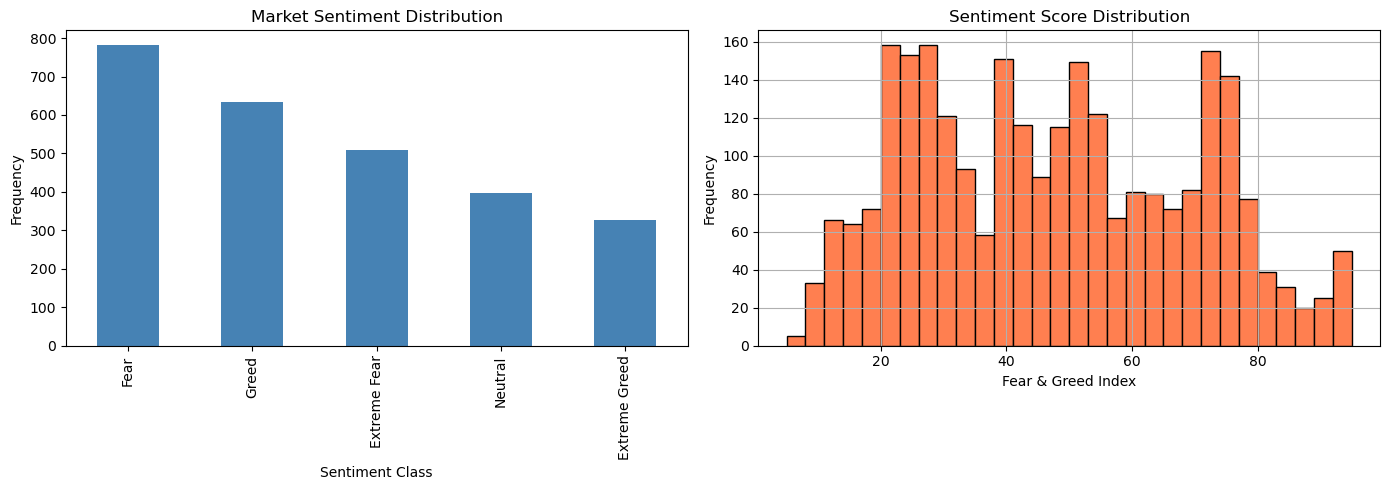

In [8]:
# Visualize sentiment distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
fear_greed['classification'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Market Sentiment Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
fear_greed['value'].hist(bins=30, color='coral', edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Fear & Greed Index')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Trading Activity by Sentiment:
   sentiment_class     Size USD    Closed PnL  Account
0    Extreme Fear   9580240.04  4.399937e+03       20
1   Extreme Greed  18223760.27  1.156894e+06       22
2            Fear  79674391.06  1.779226e+06       28
3           Greed  57045815.74  6.096325e+05       29
4         Neutral  11939551.21  7.465674e+04       16


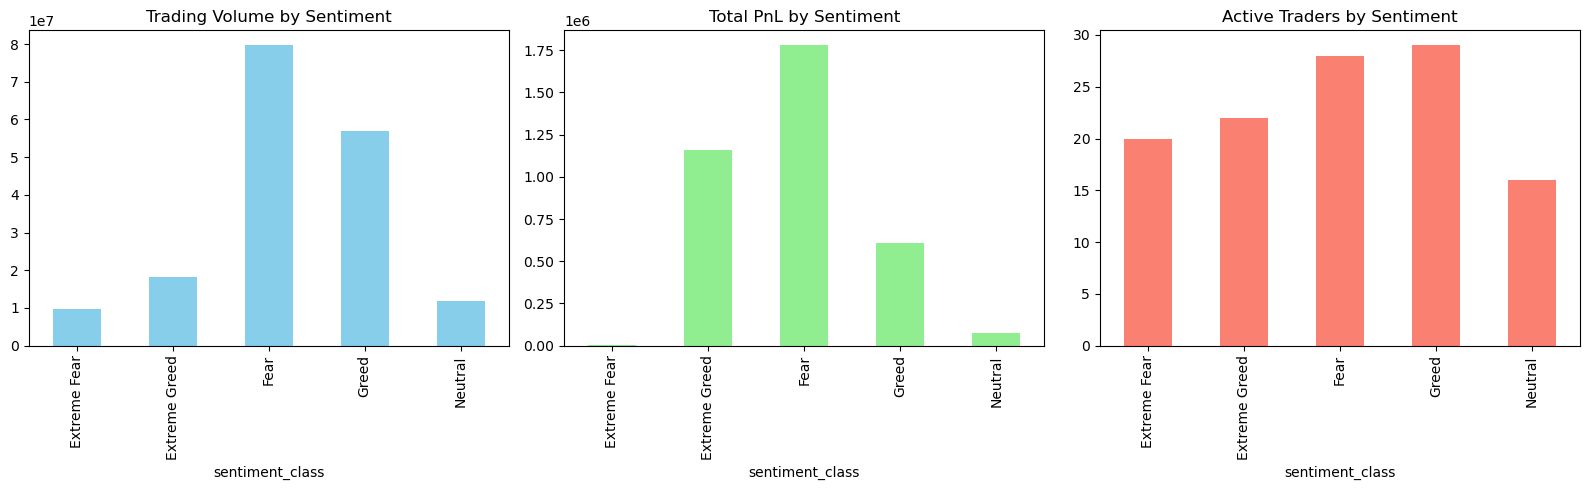

In [9]:
# Analyze trading volume by sentiment
sentiment_trading = merged_data.groupby('sentiment_class').agg({
    'Size USD': 'sum',
    'Closed PnL': 'sum',
    'Account': 'nunique'
}).reset_index()

print("Trading Activity by Sentiment:\n", sentiment_trading)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sentiment_trading.plot(x='sentiment_class', y='Size USD', kind='bar', 
                       ax=axes[0], color='skyblue', legend=False)
axes[0].set_title('Trading Volume by Sentiment')

sentiment_trading.plot(x='sentiment_class', y='Closed PnL', kind='bar', 
                       ax=axes[1], color='lightgreen', legend=False)
axes[1].set_title('Total PnL by Sentiment')

sentiment_trading.plot(x='sentiment_class', y='Account', kind='bar', 
                       ax=axes[2], color='salmon', legend=False)
axes[2].set_title('Active Traders by Sentiment')

plt.tight_layout()
plt.show()

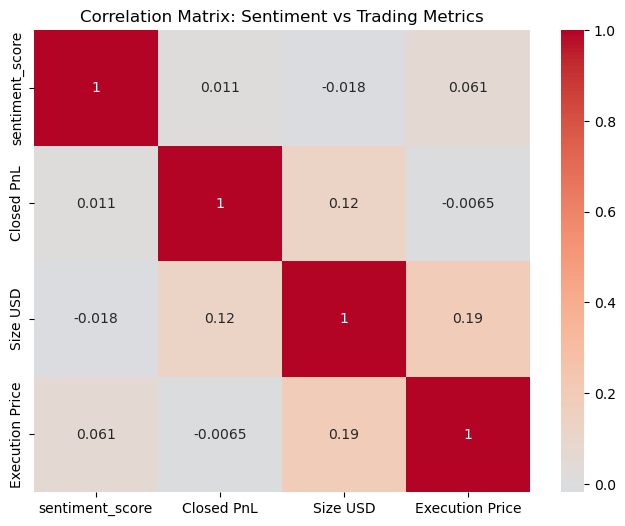

Correlation: 0.0110, P-value: 0.0372


In [10]:
# Correlation analysis
correlation_data = merged_data[['sentiment_score', 'Closed PnL', 'Size USD', 
                                'Execution Price']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Sentiment vs Trading Metrics')
plt.show()

# Statistical test
from scipy.stats import pearsonr

if merged_data['Closed PnL'].notna().sum() > 0:
    corr, p_value = pearsonr(
        merged_data['sentiment_score'].dropna(), 
        merged_data.loc[merged_data['sentiment_score'].notna(), 'Closed PnL']
    )
    print(f"Correlation: {corr:.4f}, P-value: {p_value:.4f}")

In [11]:
# Classify trades as profitable or not
merged_data['is_profitable'] = merged_data['Closed PnL'] > 0

# Group by sentiment
sentiment_performance = merged_data.groupby('sentiment_class').agg({
    'is_profitable': 'mean',
    'Closed PnL': 'mean',
    'Size USD': 'mean'
}).reset_index()

print("Performance by Sentiment:\n", sentiment_performance)

Performance by Sentiment:
   sentiment_class  is_profitable  Closed PnL     Size USD
0    Extreme Fear       0.292777    1.891632  4118.761840
1   Extreme Greed       0.553282  205.816345  3242.085086
2            Fear       0.381787  128.287950  5744.782685
3           Greed       0.435707   53.988003  5051.878829
4         Neutral       0.494920   27.088803  4332.202906


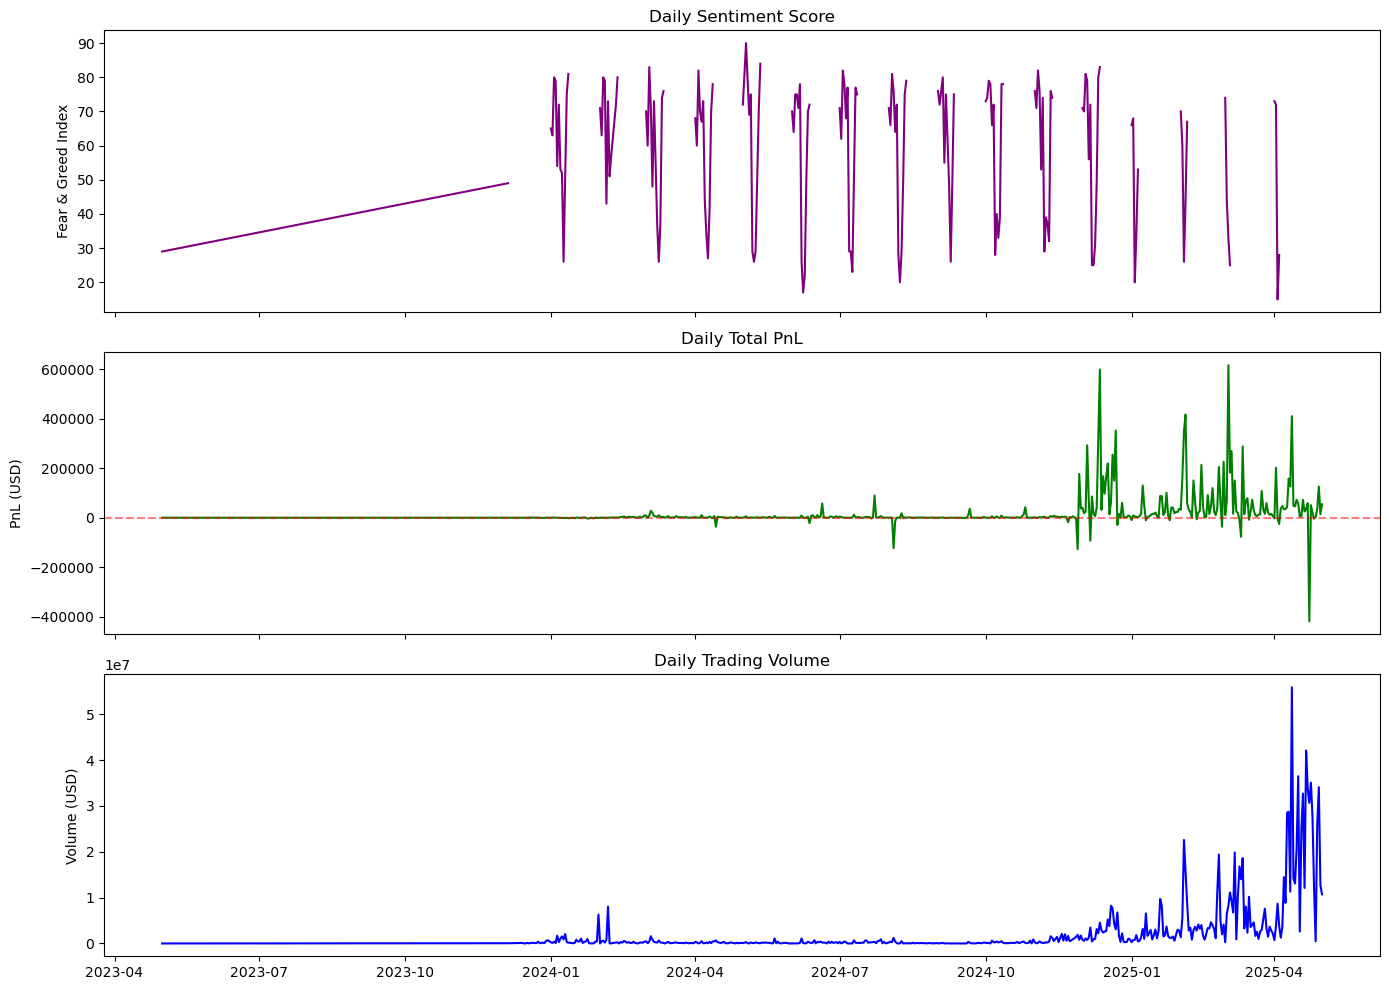

In [12]:
# Daily aggregation
daily_data = merged_data.groupby('date_only').agg({
    'sentiment_score': 'first',
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Account': 'nunique'
}).reset_index()

# Plot time series
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axes[0].plot(daily_data['date_only'], daily_data['sentiment_score'], color='purple')
axes[0].set_title('Daily Sentiment Score')
axes[0].set_ylabel('Fear & Greed Index')

axes[1].plot(daily_data['date_only'], daily_data['Closed PnL'], color='green')
axes[1].set_title('Daily Total PnL')
axes[1].set_ylabel('PnL (USD)')
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)

axes[2].plot(daily_data['date_only'], daily_data['Size USD'], color='blue')
axes[2].set_title('Daily Trading Volume')
axes[2].set_ylabel('Volume (USD)')

plt.tight_layout()
plt.show()

In [13]:
# Top performers by sentiment
def get_top_traders_by_sentiment(data, sentiment, top_n=10):
    sentiment_data = data[data['sentiment_class'] == sentiment]
    top_traders = sentiment_data.groupby('Account')['Closed PnL'].sum().nlargest(top_n)
    return top_traders

for sentiment in ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']:
    if sentiment in merged_data['sentiment_class'].unique():
        print(f"\nTop 10 Traders in {sentiment}:")
        print(get_top_traders_by_sentiment(merged_data, sentiment))


Top 10 Traders in Extreme Fear:
Account
0xbaaaf6571ab7d571043ff1e313a9609a10637864    3869.208803
0x4f93fead39b70a1824f981a54d4e55b278e9f760    3084.287743
0xaf40fdc468c30116bd3307bcbf4a451a7ebf1deb    2020.000000
0x8477e447846c758f5a675856001ea72298fd9cb5    1038.310977
0x7f4f299f74eec87806a830e3caa9afa5f2b9db8f     937.789615
0x47add9a56df66b524d5e2c1993a43cde53b6ed85     853.707848
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23     648.984412
0x28736f43f1e871e6aa8b1148d38d4994275d72c4     400.093828
0xb899e522b5715391ae1d4f137653e7906c5e2115     361.071464
0x6d6a4b953f202f8df5bed40692e7fd865318264a     298.031364
Name: Closed PnL, dtype: float64

Top 10 Traders in Fear:
Account
0x083384f897ee0f19899168e3b1bec365f52a9012    1.010607e+06
0x72c6a4624e1dffa724e6d00d64ceae698af892a0    1.972949e+05
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3    1.711983e+05
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    1.481471e+05
0x4f93fead39b70a1824f981a54d4e55b278e9f760    6.893832e+04
0xb899e522b5715391

Trading Strategy by Sentiment:
   sentiment_class  Side  Closed PnL                   Size USD
                               mean           sum          sum
0    Extreme Fear   BUY   -3.248825 -3.794627e+03   5437921.10
1    Extreme Fear  SELL    7.076480  8.194564e+03   4142318.94
2   Extreme Greed   BUY    9.047055  1.502716e+04   7575017.10
3   Extreme Greed  SELL  288.350131  1.141867e+06  10648743.17
4            Fear   BUY  210.426466  1.537586e+06  42014308.29
5            Fear  SELL   36.824047  2.416394e+05  37660082.77
6           Greed   BUY   15.661324  8.468078e+04  24972270.59
7           Greed  SELL   89.201657  5.249518e+05  32073545.15
8         Neutral   BUY   12.484274  1.273396e+04   5696430.62
9         Neutral  SELL   35.669805  6.192278e+04   6243120.59


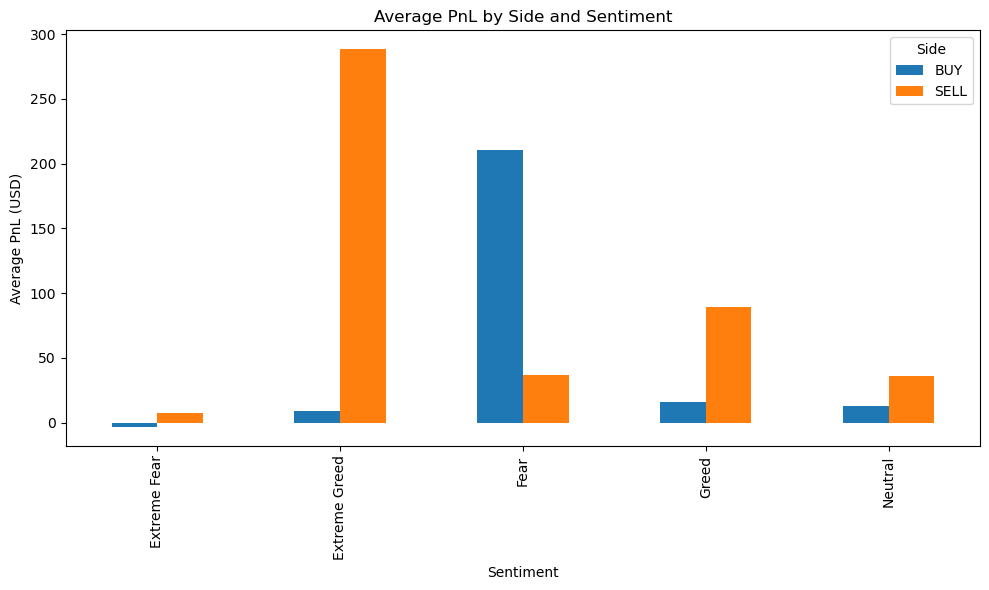

In [14]:
# Analyze buy/sell behavior by sentiment
strategy_analysis = merged_data.groupby(['sentiment_class', 'Side']).agg({
    'Closed PnL': ['mean', 'sum'],
    'Size USD': 'sum'
}).reset_index()

print("Trading Strategy by Sentiment:\n", strategy_analysis)

# Fix: Flatten the multi-level columns created by agg()
strategy_analysis.columns = ['sentiment_class', 'Side', 'pnl_mean', 'pnl_sum', 'volume_sum']

# Now pivot using the flattened column names
pivot_data = strategy_analysis.pivot_table(
    values='pnl_mean',  # Changed from ('Closed PnL', 'mean') to 'pnl_mean'
    index='sentiment_class', 
    columns='Side'
)

# Visualization
pivot_data.plot(kind='bar', figsize=(10, 6))
plt.title('Average PnL by Side and Sentiment')
plt.ylabel('Average PnL (USD)')
plt.xlabel('Sentiment')
plt.legend(title='Side')
plt.tight_layout()
plt.show()

In [15]:
# Overall summary
summary = {
    'Total Traders': merged_data['Account'].nunique(),
    'Total Trades': len(merged_data),
    'Total Volume': merged_data['Size USD'].sum(),
    'Total PnL': merged_data['Closed PnL'].sum(),
    'Avg PnL per Trade': merged_data['Closed PnL'].mean(),
    'Win Rate': (merged_data['Closed PnL'] > 0).mean(),
    'Most Common Sentiment': merged_data['sentiment_class'].mode()[0]
}

print("\n=== EXECUTIVE SUMMARY ===")
for key, value in summary.items():
    print(f"{key}: {value}")


=== EXECUTIVE SUMMARY ===
Total Traders: 32
Total Trades: 211224
Total Volume: 1191187442.4600003
Total PnL: 10296958.943436
Avg PnL per Trade: 48.74900079269401
Win Rate: 0.4112648183918494
Most Common Sentiment: Fear
